<a href="https://colab.research.google.com/github/carolinehagood/DS-4002/blob/main/05_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1.

Use the str.split() method to break the Phishing Email values into tokens: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In [2]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')

In [3]:
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

To clean the tokens, I would remove the extar punctuation in between. After I one-hot-encode them I would run a model that used the tokens as indicators that the email is a scam. The more tokens present would indicate a higher likelihood of scams.

Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [5]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

In [7]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

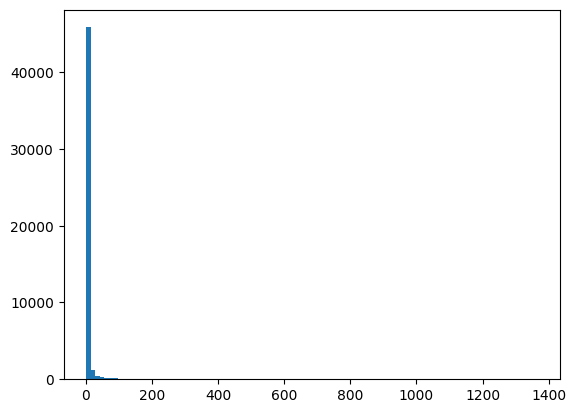

In [8]:
gdf['count'].hist(grid=False,bins=100)

Most token only occurs between 1-10 times each. The histogram is a poor illustration that there are a small number of tokens that occur closer to 1000 times.

Q3.

Load Phishing_clean.parquet. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the Email Type takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.

In [12]:
df = pd.read_parquet('https://github.com/DS3001/PCA/raw/refs/heads/main/05_PCA/Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

2. Run a regression of
 on the one-hot-encoded emails. What is the
 on the test set? On the training set?

In [13]:
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


3. What words have the largest coefficients in absolute value and most strongly influence predictions?


In [14]:
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


The top variables based on absolute value are not words but numbers which make it difficult to use those as scam indicators.

Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, Email Type) and perform a principal components analysis decomposition with two components.

In [15]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not.

<Axes: >

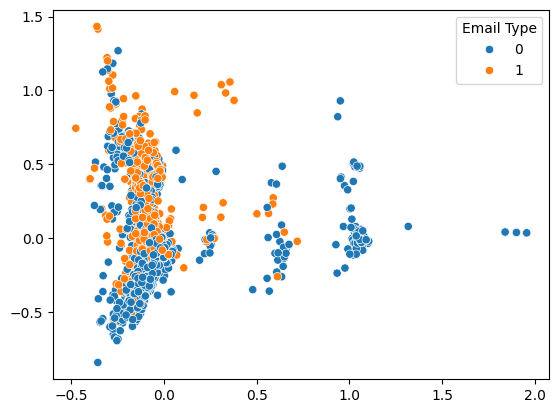

In [16]:
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

Do you notice any patterns?

The orange dots (represent scams) are very concentrated on top of the blue dots which aren't scams. They have a high first component and a low second.

Q5.

Run a linear regression of y on the first 2,610 principal components of
x. What is the R^2 on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

In [17]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


How does this performance compare to the linear regression?



This performed better than the linear regression. The test R^2 was significantly higher.

Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

When running high-dimensional regression, it is easier to avoid multi-colinearity when the covariants are independent. However, this process makes it more difficult to analyze the data beyond the words themselves.